In [1]:
# import stuff
%load_ext autoreload
%autoreload 2
%matplotlib inline

from random import randint

import numpy as np
import torch
import pandas as pd

## Load model

In [2]:
# Load model
from models import InferSent
model_version = 1
MODEL_PATH = "encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [3]:
# Keep it on CPU or put it on GPU
use_cuda = False
model = model.cuda() if use_cuda else model

In [4]:
# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = 'GloVe/glove.840B.300d.txt' if model_version == 1 else 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

In [5]:
# Load embeddings of K most frequent words
model.build_vocab_k_words(K=100000)

Vocab size : 100000


In [6]:
import pandas as pd
data = pd.read_csv('/home/jerpint/covidfaq/data/website_questions_22032020_13h00.csv')
data.dropna(inplace=True)
sentences_faq = data.question.to_list()

## Load sentences

In [ ]:
# Load some sentences
sentences = []
with open('samples.txt') as f:
    for line in f:
        sentences.append(line.strip())
print(len(sentences))

In [ ]:
sentences[:5]

## Encode sentences

In [ ]:
# gpu mode : >> 1000 sentences/s
# cpu mode : ~100 sentences/s

In [7]:
embeddings = model.encode(sentences_faq, bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))

Nb words kept : 10197/13904 (73.3%)
Speed : 166.9 sentences/s (cpu mode, bsize=128)
nb sentences encoded : 1158


## K-Means

In [28]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

cls = MiniBatchKMeans(n_clusters=6, random_state=42)
cls.fit(embeddings)


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=6, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [29]:
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(embeddings)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)


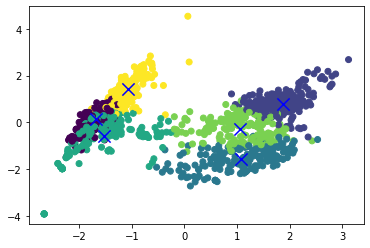

In [30]:
import matplotlib.pyplot as plt
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(embeddings))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')


In [18]:
data['cluster'] = cls.labels_
pd.set_option('display.max_rows', 300)

In [51]:
display(data[data['cluster']== 0])

,timestamp_est,anonymous_id,question,cluster
0,2020-03-18T17:57:10.427Z,7302144e-abbe-4fa4-aaf1-cf5eb674a862,What is Dialogue's position on sick notes?,0
1,2020-03-19T11:16:11.354Z,5a65a4bd-05aa-4ca8-b6da-5f807bde3294,What are Dialogue services?,0
2,2020-03-19T14:17:16.246Z,6d60c897-dd96-483d-b528-b65fcae4c1b0,Should I practice social distancing?,0
5,2020-03-19T14:05:22.01Z,b09dc15d-a003-475a-8a88-9e6a039accb6,Can I travel?,0
10,2020-03-19T14:10:37.901Z,cb2c4687-5420-4370-a4fe-776ee5d10fc4,can I go outside,0
14,2020-03-19T12:27:51.796Z,80717fa4-5254-4605-a17f-4288aad9a618,Are we all going to die?,0
17,2020-03-19T13:55:41.747Z,59eafb5a-76c4-4e07-891d-6e79276fa82d,"Bonjour,",0
31,2020-03-20T17:02:53.112Z,a061e1ea-7076-45c7-b063-fe37c9207e8f,is covid-19 dangerous,0
48,2020-03-21T10:59:53.419Z,aaa45fa5-962e-4ee1-bcef-cceb93070aa0,comment obtenir un rdv,0
65,2020-03-21T11:32:09.906Z,470bcaef-ae5a-45ad-a380-b79ad65d42b8,How often should i take my temperature?,0


In [46]:
display(data[data['cluster']== 1])

,timestamp_est,anonymous_id,question,cluster
11,2020-03-19T15:39:52.508Z,b3cd859f-a9f3-4985-a884-0a8387a9daa4,Est ce que la toux est sèche ou grasse?,1
12,2020-03-19T14:16:03.429Z,34327a70-7e54-4f53-bdf6-6809c83a8d5e,Je ne me sens pas bien,1
20,2020-03-19T18:59:07.385Z,9d2640e3-f634-4b95-85a0-4c6060c3ebaf,Est-ce que je devrais travailler de la maison?,1
33,2020-03-20T16:29:58.774Z,4a67e634-6653-4a89-9b7c-ff3fcb6153ec,Désolé e. C'est fini! Merci,1
44,2020-03-21T11:25:45.462Z,243ce221-7ad9-4421-9c34-f078bb5f4461,Peut-on avoir la COVID-19 2 fois?,1
46,2020-03-21T11:40:04.219Z,863d125e-dfb0-4638-aaba-d191ac9bb9e9,Est ce que la question: arrivez vous de voyage...,1
49,2020-03-21T11:25:45.451Z,243ce221-7ad9-4421-9c34-f078bb5f4461,Quels sont les premiers symptômes à apparaître?,1
54,2020-03-21T10:23:56.851Z,9e7442fc-dbbd-4e6b-ac35-f0cc7df8c6b4,Quels sont les symptômes du covid-19?,1
55,2020-03-21T08:53:40.791Z,54d87c36-4a7d-4b0b-9463-cab2e01db270,mes oiseaux risquent ils d'attrapper le covid-19,1
56,2020-03-21T10:59:53.353Z,aaa45fa5-962e-4ee1-bcef-cceb93070aa0,"l'allocation familiale annoncée, elle sera ver...",1


In [47]:
display(data[data['cluster']== 2])

,timestamp_est,anonymous_id,question,cluster
6,2020-03-19T13:47:48.848Z,0b0df84f-dcc5-42c0-980e-bafacd3bbdbe,"Je fais une sarcoidose pulmonaire, je suis tu ...",2
21,2020-03-19T18:08:56.871Z,d4b6deb3-886d-4746-81bf-3a1f6892b085,Si j'ai des symptômes faible (toux seulement) ...,2
22,2020-03-19T19:40:32.987Z,328ca7d6-c2c6-4977-897d-88e8066163e7,J’ai une fièvre est ce que je dois rester chez...,2
23,2020-03-20T10:58:39.806Z,6a7eff0e-2446-4545-b16d-9b642051e9bf,que dois-je faire si je travail et je suis malade,2
24,2020-03-20T11:08:16.057Z,2cf1d255-62d3-4f65-869e-d08648c25dbe,Je suis pharmacienne communautaire et je prend...,2
25,2020-03-20T11:14:07.001Z,10f6c51e-8097-469e-9f77-ed67e039c9b5,Info santé 811 nous a dit qu'il nous appelerai...,2
26,2020-03-20T10:32:08.412Z,f02c477f-ca49-43d3-a93b-cfed6cffa34c,je vous contacte pour mon conjoint qui n’a pas...,2
29,2020-03-20T11:13:42.652Z,fcf2a352-45da-40b5-9fb3-9684ab71b49c,J aimerai savoir mes fille 3 ans et 4 ans son ...,2
30,2020-03-20T11:08:16.062Z,2cf1d255-62d3-4f65-869e-d08648c25dbe,Je me demande s'il serait mieux de cesser le t...,2
37,2020-03-20T12:41:18.293Z,afaf41f0-251f-4351-916b-c4090e06f920,Pouvez vous me décrire la différence entre tou...,2


In [48]:
data[data['cluster']== 3]

,timestamp_est,anonymous_id,question,cluster
3,2020-03-19T14:00:19.88Z,71a29314-2b32-43d5-b09a-1795a5380e60,LP TEST question,3
4,2020-03-19T14:16:05.351Z,f264fd4b-de03-4dc0-8531-fa9d0a1b0633,I'd love to know how long I can be contagious?,3
7,2020-03-19T13:40:44.882Z,f75ca552-9cf8-4f52-8151-25c0cea0a8b0,Get I get infected from a dog?,3
8,2020-03-19T23:02:18.034Z,58cd9504-720d-44cd-89a2-4cc83cde7b90,Someone from quarantaine came to my office and...,3
9,2020-03-19T14:20:00.831Z,8939cba6-f923-44fe-9cf4-8a56e198778b,What is the difference between a pandemic & ep...,3
13,2020-03-19T14:08:51.894Z,04fd4b84-3015-492f-aa37-eacf6e432a70,If you start showing flu symptoms should you c...,3
15,2020-03-19T14:40:42.773Z,4c2c5c1b-2327-45d5-8c63-901cac28ea30,Can I go for a run? Does running/exercise comp...,3
16,2020-03-19T14:17:16.25Z,6d60c897-dd96-483d-b528-b65fcae4c1b0,If I think I have symptoms of COVID19 should I...,3
18,2020-03-19T14:06:17.831Z,f75ca552-9cf8-4f52-8151-25c0cea0a8b0,"I had an asthma attack when I was young, but d...",3
19,2020-03-19T17:59:25.201Z,ce80a1dc-7cbd-4922-8b00-b491a17da62e,mental health,3


In [49]:
data[data['cluster']== 4]

,timestamp_est,anonymous_id,question,cluster
34,2020-03-20T12:41:18.285Z,afaf41f0-251f-4351-916b-c4090e06f920,L’écoulement nasal est-il un symptôme ?,4
41,2020-03-20T20:18:35.88Z,7bf79286-b8fe-4aa0-a9f0-cb53d3e77ddd,pourquoi dois-je être en confinement,4
50,2020-03-21T11:05:05.967Z,3e49cb8e-c3da-4192-ac69-85ac0b50cfe0,Dois-je entrer travailler si je suis immunosup...,4
67,2020-03-21T10:59:53.427Z,aaa45fa5-962e-4ee1-bcef-cceb93070aa0,comment avoir un rendez vous,4
76,2020-03-21T10:59:53.402Z,aaa45fa5-962e-4ee1-bcef-cceb93070aa0,suis-je a risque,4
82,2020-03-21T11:48:53.564Z,87588af0-5b62-46e0-8990-869114b8312e,Puis-je m’isoler volontairement et être payer ?,4
115,2020-03-21T10:59:53.385Z,aaa45fa5-962e-4ee1-bcef-cceb93070aa0,j'ai besoin d'aide je crois,4
142,2020-03-21T14:14:42.311Z,a4c13d0e-cdbc-48a8-b24a-7135ec3ed285,Le coronavirus survit-il quand une personne co...,4
155,2020-03-21T14:00:29.15Z,0ca32b20-b512-414f-b84c-5f966c4cb042,Comment puis-je me faire tester?,4
166,2020-03-21T15:22:57.414Z,9b1c0bfc-6f52-47df-bed9-cc5a7d292d07,Combien de temps dure un rhume normalement ?,4


In [50]:
data[data['cluster']== 5]

,timestamp_est,anonymous_id,question,cluster


## Visualization

In [ ]:
np.linalg.norm(model.encode(['the cat eats.']))

In [ ]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [ ]:
cosine(model.encode(['the cat eats.'])[0], model.encode(['the cat drinks.'])[0])

In [ ]:
idx = randint(0, len(sentences))
_, _ = model.visualize(sentences[idx])

In [ ]:
my_sent = 'The cat is drinking milk.'
_, _ = model.visualize(my_sent)

In [ ]:
model.build_vocab_k_words(500000) # getting 500K words vocab
my_sent = 'barack-obama is the former president of the United-States.'
_, _ = model.visualize(my_sent)

In [ ]:
len(embeddings)